# African Antelope Classification using FastAI

An interactive notebook with an end-to-end case study of creating a custom image dataset of major African antelope and training a deep convolutional neural network to classify each species.

An in depth discussion of the case study is available at: https://www.avanwyk.com/african-antelope-fastai-image-classifier

The basic workflow is as follows:
1. Download images of each antelope and build a dataset.
2. Pre-process and prepare the dataset for learning.
3. Create a deep neural network model for classification.
4. Train the DNN using transfer learning on the data.
5. Validate and evaluate the model.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
from antelope_classification import *

In [4]:
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)
logging.getLogger('PIL').setLevel(logging.WARNING)

In [5]:
antelopes = ANTELOPE; print(antelopes)

['kudu', 'eland', 'sable antelope', 'roan antelope', 'waterbuck', 'impala antelope', 'nyala', 'bushbuck', 'tsessebe', 'lichtensteins hartebeest', 'grey duiker', 'steenbok', 'klipspringer']


## Download image data

Here we download images to the data directory; each species (class) is added to its own directory in accordance with the imagenet dataset format. We also check whether the image file names indicate any potential mislabeling.

In [6]:
download_antelope_images(DATA_PATH)

INFO:root:Directory 'data' is not empty. Skipping image download.


In [7]:
validate_labels(DATA_PATH, ANTELOPE)

INFO:root:Potential mislabeling: data/kudu/nyalakudujpg
INFO:root:Potential mislabeling: data/kudu/nyalakudujpg
INFO:root:Potential mislabeling: data/waterbuck/elandfemaleiixpxjpg
INFO:root:Potential mislabeling: data/nyala/differencebetweenkuduandnyalajpg


*100* examples (50 male/50 female) of each class is downloaded, for a total dataset size of 1300 images. This was manually cleaned leaving roughly 1100 images.

The label validation shows a few potential mislabels, all of which are from species comparison images, and are in fact labeled correctly.

Further manual inspection of the data should be done to ensure there are no other examples that are mislabeled or inappriopate for the task at hand.

## Build and visualize datasets

With the data downloaded, we can construct an [ImageDataBunch](https://docs.fast.ai/vision.data.html#ImageDataBunch) with the default transforms. The image data is normalized with the imagenet statistics.

In [8]:
DATA_PATH = Path('data')
VALID_PCT = 0.2
IMAGE_SIZE = 224
BATCH_SIZE = 16

In [9]:
image_data = ImageDataBunch.from_folder(DATA_PATH, valid_pct=VALID_PCT,\
                                            ds_tfms=get_transforms(), size=IMAGE_SIZE,
                                            bs=BATCH_SIZE).normalize(imagenet_stats)

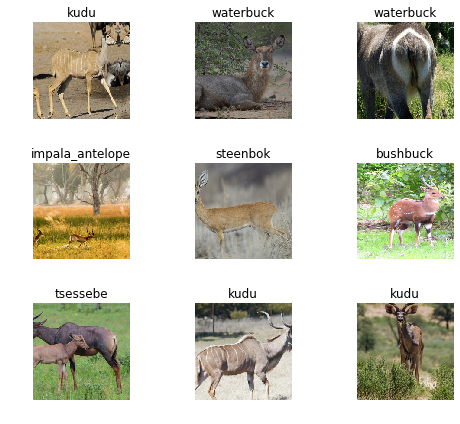

In [10]:
image_data.show_batch(3, figsize=(7,6))

In [11]:
print(image_data.classes)
len(image_data.classes) == image_data.c == len(ANTELOPE)

['bushbuck', 'eland', 'grey_duiker', 'impala_antelope', 'klipspringer', 'kudu', 'lichtensteins_hartebeest', 'nyala', 'roan_antelope', 'sable_antelope', 'steenbok', 'tsessebe', 'waterbuck']


True

We visualize a batch of data to get an idea of what will be passed to the CNN. We also validate that the ImageDataBunch correctly picked all of our classes, which it did.

## Create Pre-trained Model

In [12]:
ARCHITECTURE = models.resnet50

We now create a Resnet50 based CNN model pre-trained on the Imagenet dataset.

In [13]:
learn = cnn_learner(image_data, ARCHITECTURE, metrics=[error_rate])

In [14]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

## Train Model (top layer)

In the first stage of training, we only fit the final, fully-connected layers of the ResNet (also referred to as fine-tuning). We must also first find an appropriate learning rate to use.

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


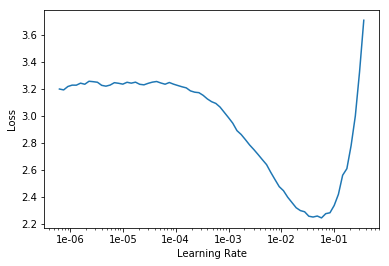

In [16]:
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(4, max_lr=slice(1e-3, 1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,1.352547,0.909331,0.281369,00:14
1,1.032153,0.774388,0.205323,00:13
2,0.737094,0.570336,0.178707,00:13
3,0.476649,0.451232,0.129278,00:13


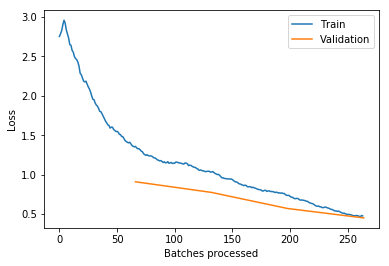

In [18]:
learn.recorder.plot_losses()

In [19]:
learn.save('stage-1')

We train the network for 5 epochs using the learning rate range we found using `lr_find`. The network achieves and accuracy of about 88% after the initial training.

### Results and Interpretation

With the model trained we can investigate where the model is struggling and validate its accuracy.

In [20]:
from sklearn.metrics import f1_score

In [21]:
interp = ClassificationInterpretation.from_learner(learn)

In [22]:
losses, idxs = interp.top_losses()

In [23]:
len(image_data.valid_ds) == len(losses)

True

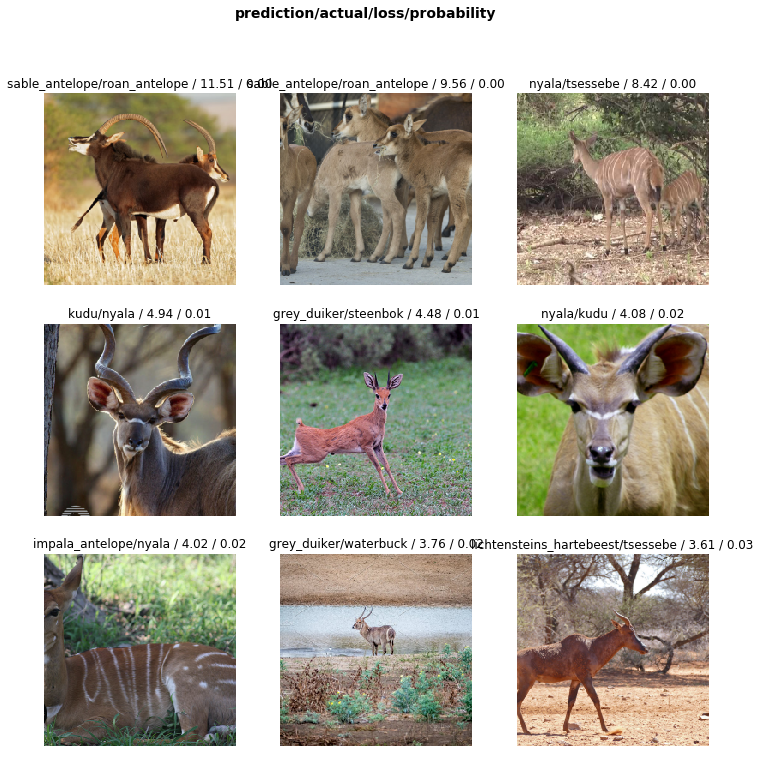

In [24]:
interp.plot_top_losses(9, heatmap=False)

Through plotting the top losses we can visually inspect the images that the model is struggling with the most. There are a number of duplicate images. The model also seems to struggle with close-up and front side views of the antelope.

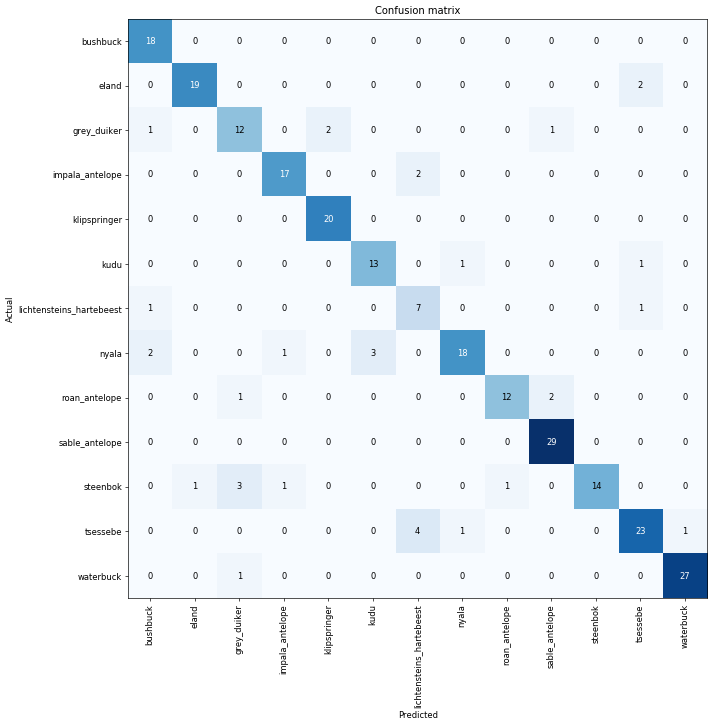

In [25]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [26]:
interp.most_confused(min_val=2)

[('tsessebe', 'lichtensteins_hartebeest', 4),
 ('nyala', 'kudu', 3),
 ('steenbok', 'grey_duiker', 3),
 ('eland', 'tsessebe', 2),
 ('grey_duiker', 'klipspringer', 2),
 ('impala_antelope', 'lichtensteins_hartebeest', 2),
 ('nyala', 'bushbuck', 2),
 ('roan_antelope', 'sable_antelope', 2)]

In [27]:
preds, targets = learn.TTA()
predicted_classes = np.argmax(preds, axis=1)

f1_score(targets, predicted_classes, average='micro')

0.9163498098859315

Using test time augmentation we calculate a final F1 score of 0.9277 after the first stage of training.

## Model Assisted Data Cleaning

We can used the trained model to help us clean up the dataset by looking at images which has the highest loss values and using the FastAI [ImageCleaner](https://docs.fast.ai/widgets.image_cleaner.html) widget.

### Additional Data

In order to address some of the shortcomings in the first stage model, mainly the lack of examples with a frontal view of the antelope, we download additional data, specfying a 'front' as keyword.

In [28]:
download_antelope_images(Path('add_data'), limit=10, kws=['"front"'])

INFO:root:Directory 'add_data' is not empty. Skipping image download.


The additional data can now be merged with the data directory.

### Revisition Augmentation Transforms

Another thing we can take a closer look at is the image transformations applied to augment the dataset. We can modify the transforms slightly to better suit our use case.

In [29]:
def custom_transforms():
    transforms = get_transforms(max_rotate=5, p_affine=0.85, p_lighting=0.5)
    # replace zoom with our own version
    transforms[0][4] = RandTransform(tfm=TfmAffine(zoom), kwargs={'scale': (0.6, 1.1)}, p=0.85)
    return transforms

### Data Clean-up

We need to re-train the model on the new dataset that includes the additional images we downloaded and the new updated image transforms. Then we can use the model itself to clean the dataset.

In [30]:
image_data = ImageDataBunch.from_folder(DATA_PATH, valid_pct=VALID_PCT,\
                                            ds_tfms=custom_transforms(), size=IMAGE_SIZE,
                                            bs=BATCH_SIZE).normalize(imagenet_stats)

In [31]:
learn = cnn_learner(image_data, ARCHITECTURE, metrics=[error_rate])
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


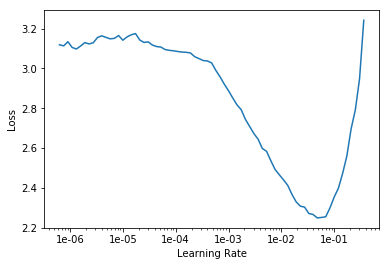

In [32]:
learn.recorder.plot()

In [33]:
learn.fit_one_cycle(4, max_lr=slice(3e-3, 1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,1.395987,1.147864,0.338403,00:13
1,1.162618,1.174923,0.342205,00:13
2,0.893066,0.592114,0.163498,00:13
3,0.620655,0.525260,0.121673,00:13


In [34]:
from fastai.widgets import *

In [35]:
images = (ImageList.from_folder(DATA_PATH)
                   .split_none()
                   .label_from_folder()
                   .transform(custom_transforms(), size=224)
                   .databunch())

In [36]:
ds, idxs = DatasetFormatter().from_toplosses(learn)

In [37]:
ImageCleaner(ds, idxs, DATA_PATH)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

## Full Model Training

The ImageCleaner widget does not modify the data itself, but instead creates a `.csv` file that contains the paths of the cleaned data. We therefore need to read the CSV into a dataframe and build the ImageDataBunch from that.

In [38]:
np.random.seed(111)

In [39]:
df = pd.read_csv(DATA_PATH/'cleaned.csv', header='infer')
image_data = ImageDataBunch.from_df(DATA_PATH, df, valid_pct=VALID_PCT,\
                                            ds_tfms=custom_transforms(), size=IMAGE_SIZE,
                                            bs=BATCH_SIZE).normalize(imagenet_stats)

In [40]:
learn = cnn_learner(image_data, ARCHITECTURE, metrics=[error_rate])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


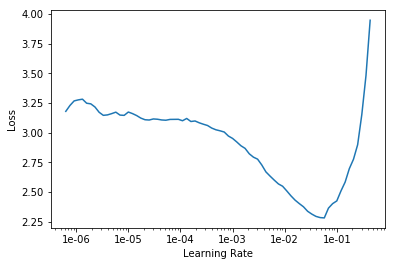

In [41]:
learn.lr_find()
learn.recorder.plot()

In [42]:
learn.fit_one_cycle(4, max_lr=slice(1e-3, 1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,1.526080,0.751208,0.232227,00:12
1,1.108684,0.697950,0.227488,00:11
2,0.804617,0.488560,0.203791,00:11
3,0.594004,0.431559,0.170616,00:11


To improve the network's performance, we can proceed with unfreezing the model, allowing us to train all the layers of the ResNet (instead of just fine tuning the final layers as with stage-1).

In [43]:
learn.unfreeze()

In [44]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


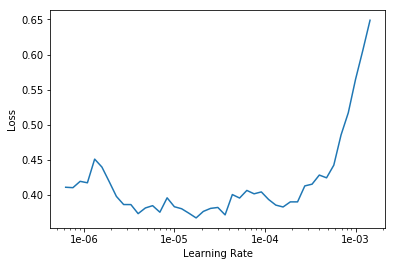

In [45]:
learn.recorder.plot()

In [46]:
learn.fit_one_cycle(5, max_lr=7e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.400648,0.361140,0.123223,00:14
1,0.403189,0.409481,0.123223,00:14
2,0.354099,0.396077,0.127962,00:14
3,0.257901,0.346639,0.132701,00:14
4,0.204208,0.314538,0.118483,00:14


In [47]:
learn.save('stage-2-a')

Finally we train the model for much longer with a small learning rate.

In [48]:
learn.fit_one_cycle(20, max_lr=7e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.154993,0.311427,0.127962,00:14
1,0.185968,0.302535,0.127962,00:14
2,0.167942,0.291734,0.109005,00:14
3,0.181434,0.298713,0.094787,00:14
4,0.190612,0.400196,0.118483,00:14
5,0.209943,0.414060,0.118483,00:14
6,0.226450,0.462790,0.132701,00:14
7,0.248497,0.382834,0.113744,00:14
8,0.189046,0.343103,0.113744,00:14
9,0.141687,0.378920,0.132701,00:14


In [49]:
learn.save('stage-2-b')

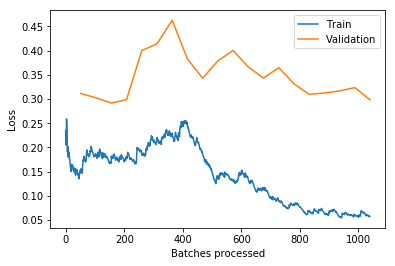

In [50]:
learn.recorder.plot_losses()

The model's validation accuracy improves to 87%. A training loss of 0.0487 is reached, but is still improving after the 20 epochs indicating it might be worthwhile to train the model further.

### Results and Interpretation

We again analyze the performance and validate the F1 score.

In [51]:
interp = ClassificationInterpretation.from_learner(learn)

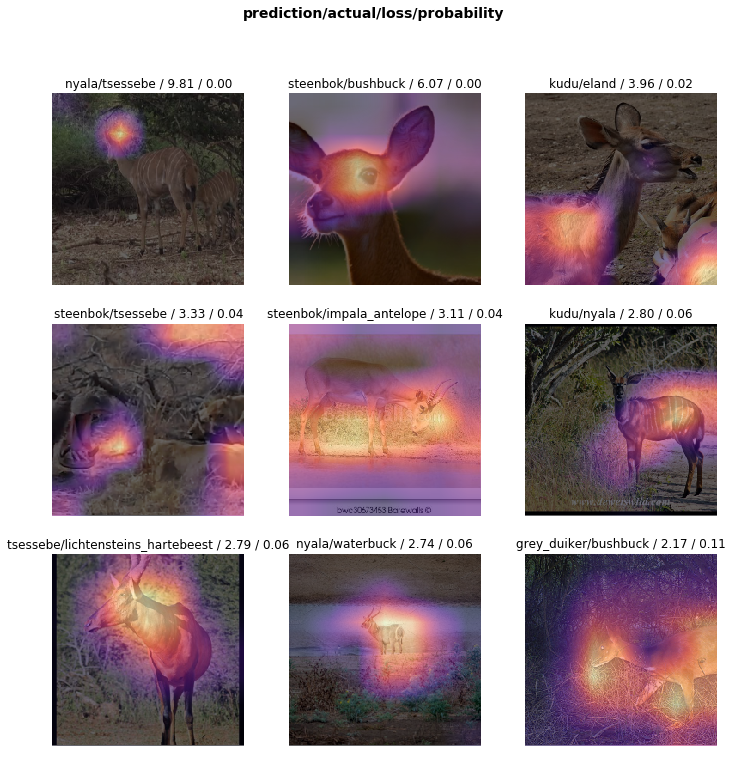

In [52]:
interp.plot_top_losses(9, figsize=(12,12), heatmap=True)

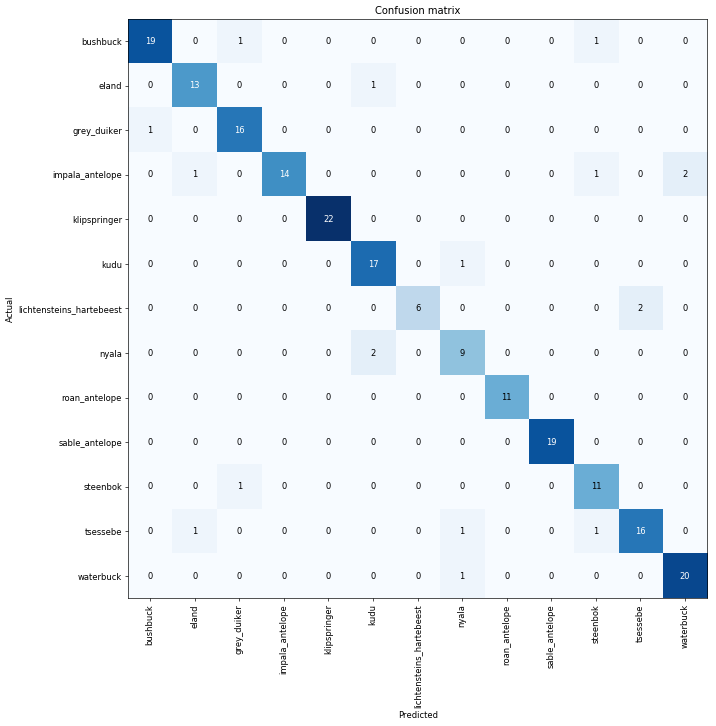

In [53]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [54]:
interp.most_confused(min_val=2)

[('impala_antelope', 'waterbuck', 2),
 ('lichtensteins_hartebeest', 'tsessebe', 2),
 ('nyala', 'kudu', 2)]

The network is more confident in its prediction of some of the classes.

When looking at the examples with the highest loss, we note that the network is struggling the most with images of close-ups of the antelope's faces, a potential gap in the data we gathered.

### Final F1 Score with Test Time Augmentation

In [55]:
preds, targets = learn.TTA()
predicted_classes = np.argmax(preds, axis=1)

f1_score(targets, predicted_classes, average='micro')

0.9004739336492891

## Further Improvement

With only 880 training examples (20% of the dataset was used for validation), ~85 per class, the network achieves a final F1 score of 0.90 with TTA after 24 epochs of training. This is pretty good, but I expect it can be improved upon. Potential areas to investigate are:

- Validate the transformations used to augment the dataset (especially rotation and colour).
- Gather more data, especially of examples of specific edge cases (such as the close-up of antelope faces).